# 토마토 꽃 데이터 학습을 위한 프로토 타입 코드 2

- 연습 버전
- 최종 목표는 이진 분류를 통해 3개화 이상의 화방과 2개화 이하의 화방을 분류하는것이 최종 목표
    - 더 궁극적으로는 개화 개수를 알면 더욱 좋다
    

- 현재 코드는 미개화군, 개화군 화방을 분류 해보는 이진 코드를 작성

- CNN 학습
- 학습 데이터의 특징
    - 약 1300개의 데이터를 통한 학습
    - 화방당 0~2개의 개화는 미개화군, 화방당 3개 이상의 개화는 개화군으로 분류 
    - 모든 개화수는 1화방당으로 정의 


### 데이터 준비
##### 현재는 일단 코드 뼈대부터 제작하기 위해 미개화 100개, 개화 1개 100개, 개화 2개 100개의 이미지를 통해 코드 구현 

In [1]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# 라벨링: 0 - 3개 미만, 1 - 3개 이상
class_dirs = {
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/unblossomed': 0,       # 미개화 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_1': 0,       # 개화 1개 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_2': 0,       # 개화 2개 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_3/rotated': 1# 개화 3개 이상 디렉토리 경로
}

# 이진 분류하기 위해 0과1 작성
# 클래스별 파일 경로

In [3]:
# 이미지 파일 경로와 라벨 저장할 리스트
# 각 클래스 폴더에서 100개씩 이미지 파일 경로를 불러와 image_paths에 저장
image_paths = []
labels = []



In [4]:
# 라벨은 클래스 번호로 지정 (0부터 시작)
for class_dir, label in class_dirs.items():
    paths = glob.glob(f'{class_dir}/*.jpg')     
    for path in paths:
        image_paths.append(path)
        labels.append(label)
        


In [5]:
# 이미지 로딩 및 전처리
# 모든 이미지가 너무 커서 전처리 작업 필요
# 원래 이미지가 거의 3000*4000의 픽셀을 가지기에 300*400으로 축소

images = np.array([img_to_array(load_img(img, target_size=(400, 300))) for img in image_paths])

# 라벨을 NumPy 배열로 변환
labels = np.array(labels)

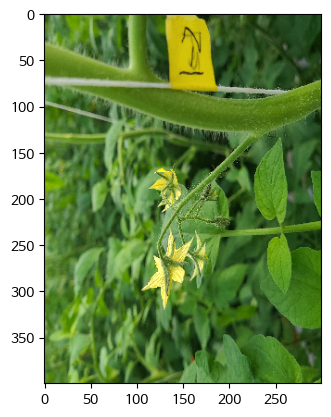

In [6]:
import matplotlib.pyplot as plt
# 1131번째 이미지 확인
img = images[1531]

# 이미지 확인
plt.imshow(img.astype(int))  # 이미지 데이터는 float 형태이므로 int로 변환
plt.show()

In [7]:
# train-test split
# test 사이즈는 0.2로 지정
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}


In [9]:
# CNN 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(400, 300, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

In [10]:
# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 149, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 199, 149, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 71, 64)        3

In [12]:
# 모델 학습
history = model.fit(
    x_train, 
    y_train, 
    class_weight=class_weight_dict, 
    epochs=30, 
    batch_size=64, 
    validation_data=(x_test, y_test)
)

Epoch 1/30


24/24 [==============================] - 77s 3s/step - loss: 93.9104 - accuracy: 0.5733 - val_loss: 6.0295 - val_accuracy: 0.8587
Epoch 2/30
24/24 [==============================] - 66s 3s/step - loss: 19.9210 - accuracy: 0.7160 - val_loss: 6.6133 - val_accuracy: 0.7520
Epoch 3/30
24/24 [==============================] - 66s 3s/step - loss: 5.4205 - accuracy: 0.8140 - val_loss: 4.2739 - val_accuracy: 0.7493
Epoch 4/30
24/24 [==============================] - 67s 3s/step - loss: 2.1417 - accuracy: 0.8053 - val_loss: 1.2957 - val_accuracy: 0.7947
Epoch 5/30
24/24 [==============================] - 66s 3s/step - loss: 1.0896 - accuracy: 0.8153 - val_loss: 0.9545 - val_accuracy: 0.8000
Epoch 6/30
24/24 [==============================] - 67s 3s/step - loss: 1.0172 - accuracy: 0.8193 - val_loss: 1.0123 - val_accuracy: 0.7973
Epoch 7/30
24/24 [==============================] - 66s 3s/step - loss: 0.8329 - accuracy: 0.8513 - val_loss: 0.9162 - val_accuracy: 0.8027
Epoch 8/30
24/24

In [13]:
# 학습 과정에서의 손실과 정확도 그래프 작성
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

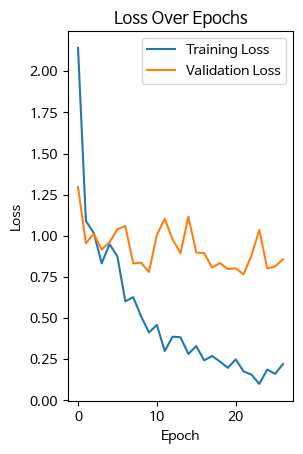

In [14]:
# 손실 그래프
plt.subplot(1, 2, 1)
# 첫 3개의 데이터 포인트를 제외하고 손실 데이터를 슬라이싱하여 플롯
plt.plot(history.history['loss'][3:], label='Training Loss')
plt.plot(history.history['val_loss'][3:], label='Validation Loss')

# 그래프의 나머지 부분 설정
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

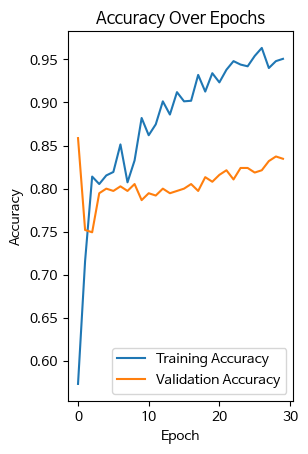

In [15]:
# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 0s 77ms/step


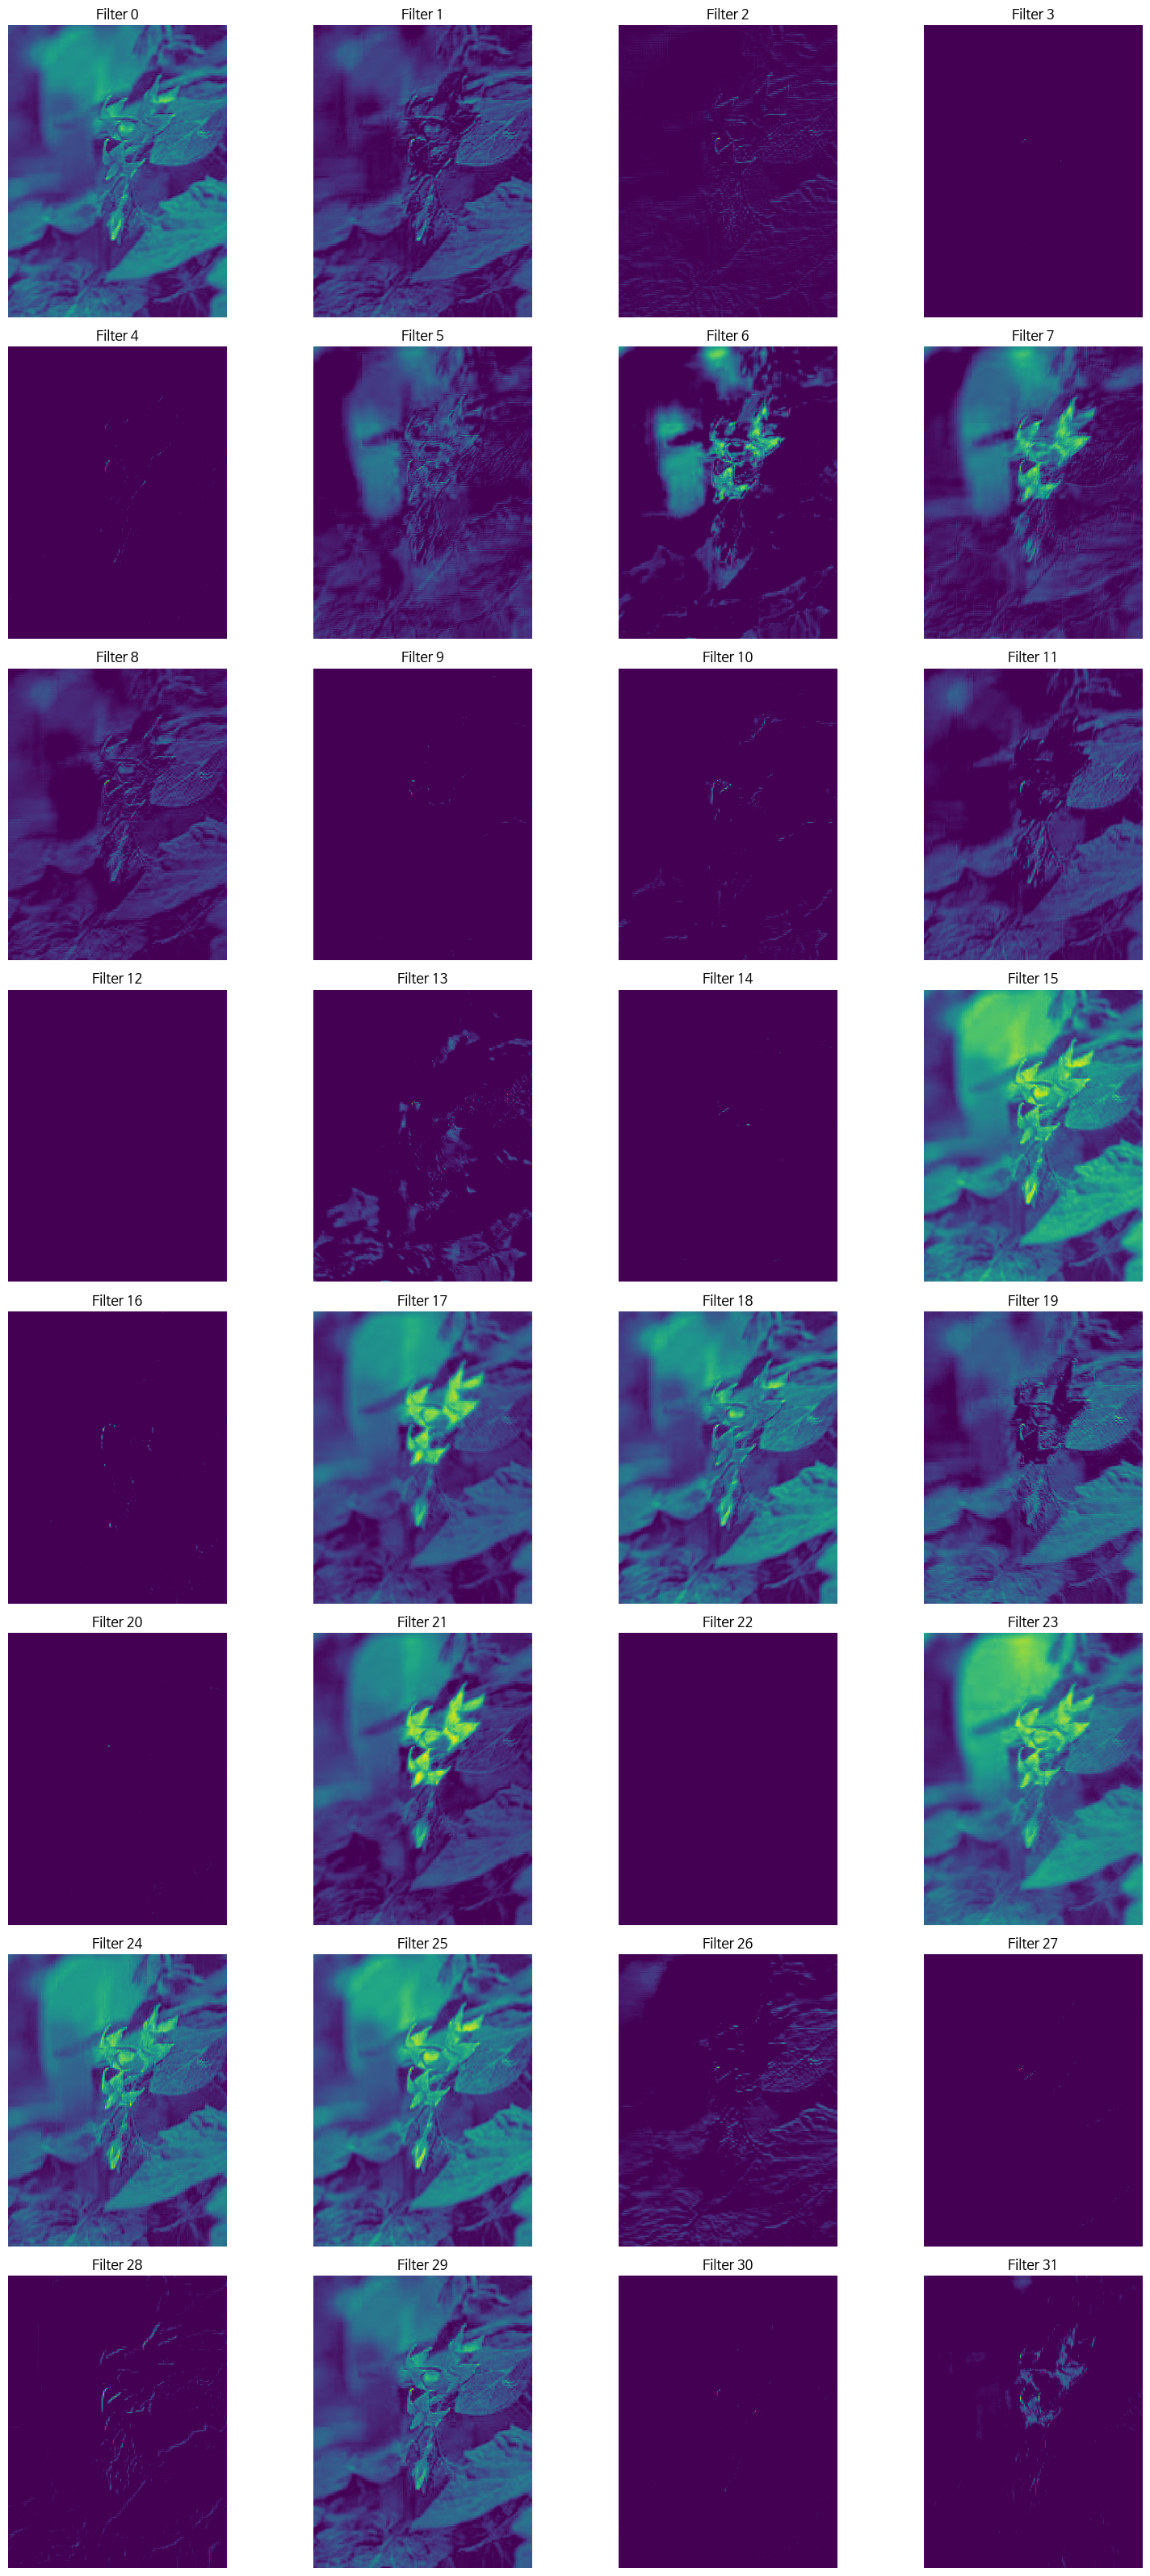

In [26]:
from keras import models
import matplotlib.pyplot as plt

# 활성화 맵을 시각화하는 함수 정의
def plot_activation_maps(activations, layer_index, num_rows=8, num_cols=4):
    layer_activation = activations[layer_index]
    num_features = layer_activation.shape[-1]
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in range(num_features):
        ax = axes[i]
        # 특성 맵의 i번째 채널을 추출
        feature_map = layer_activation[0, :, :, i]
        # 필터의 활성화를 시각화
        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f'Filter {i}')
        ax.axis('off')

    # 남은 서브플롯을 숨김
    for i in range(num_features, num_rows * num_cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 이미지 선택
selected_image = x_train[200]  # 이곳에 특성 맵을 보고 싶은 이미지의 인덱스를 입력
selected_image = np.expand_dims(selected_image, axis=0)

# 활성화 맵 계산
layer_outputs = [layer.output for layer in model.layers[:8]]  # 처음 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # 이 출력으로 모델을 생성
activations = activation_model.predict(selected_image)

# 활성화 맵 시각화
plot_activation_maps(activations, layer_index=0)  # 'layer_index'는 시각화하고 싶은 층의 인덱스


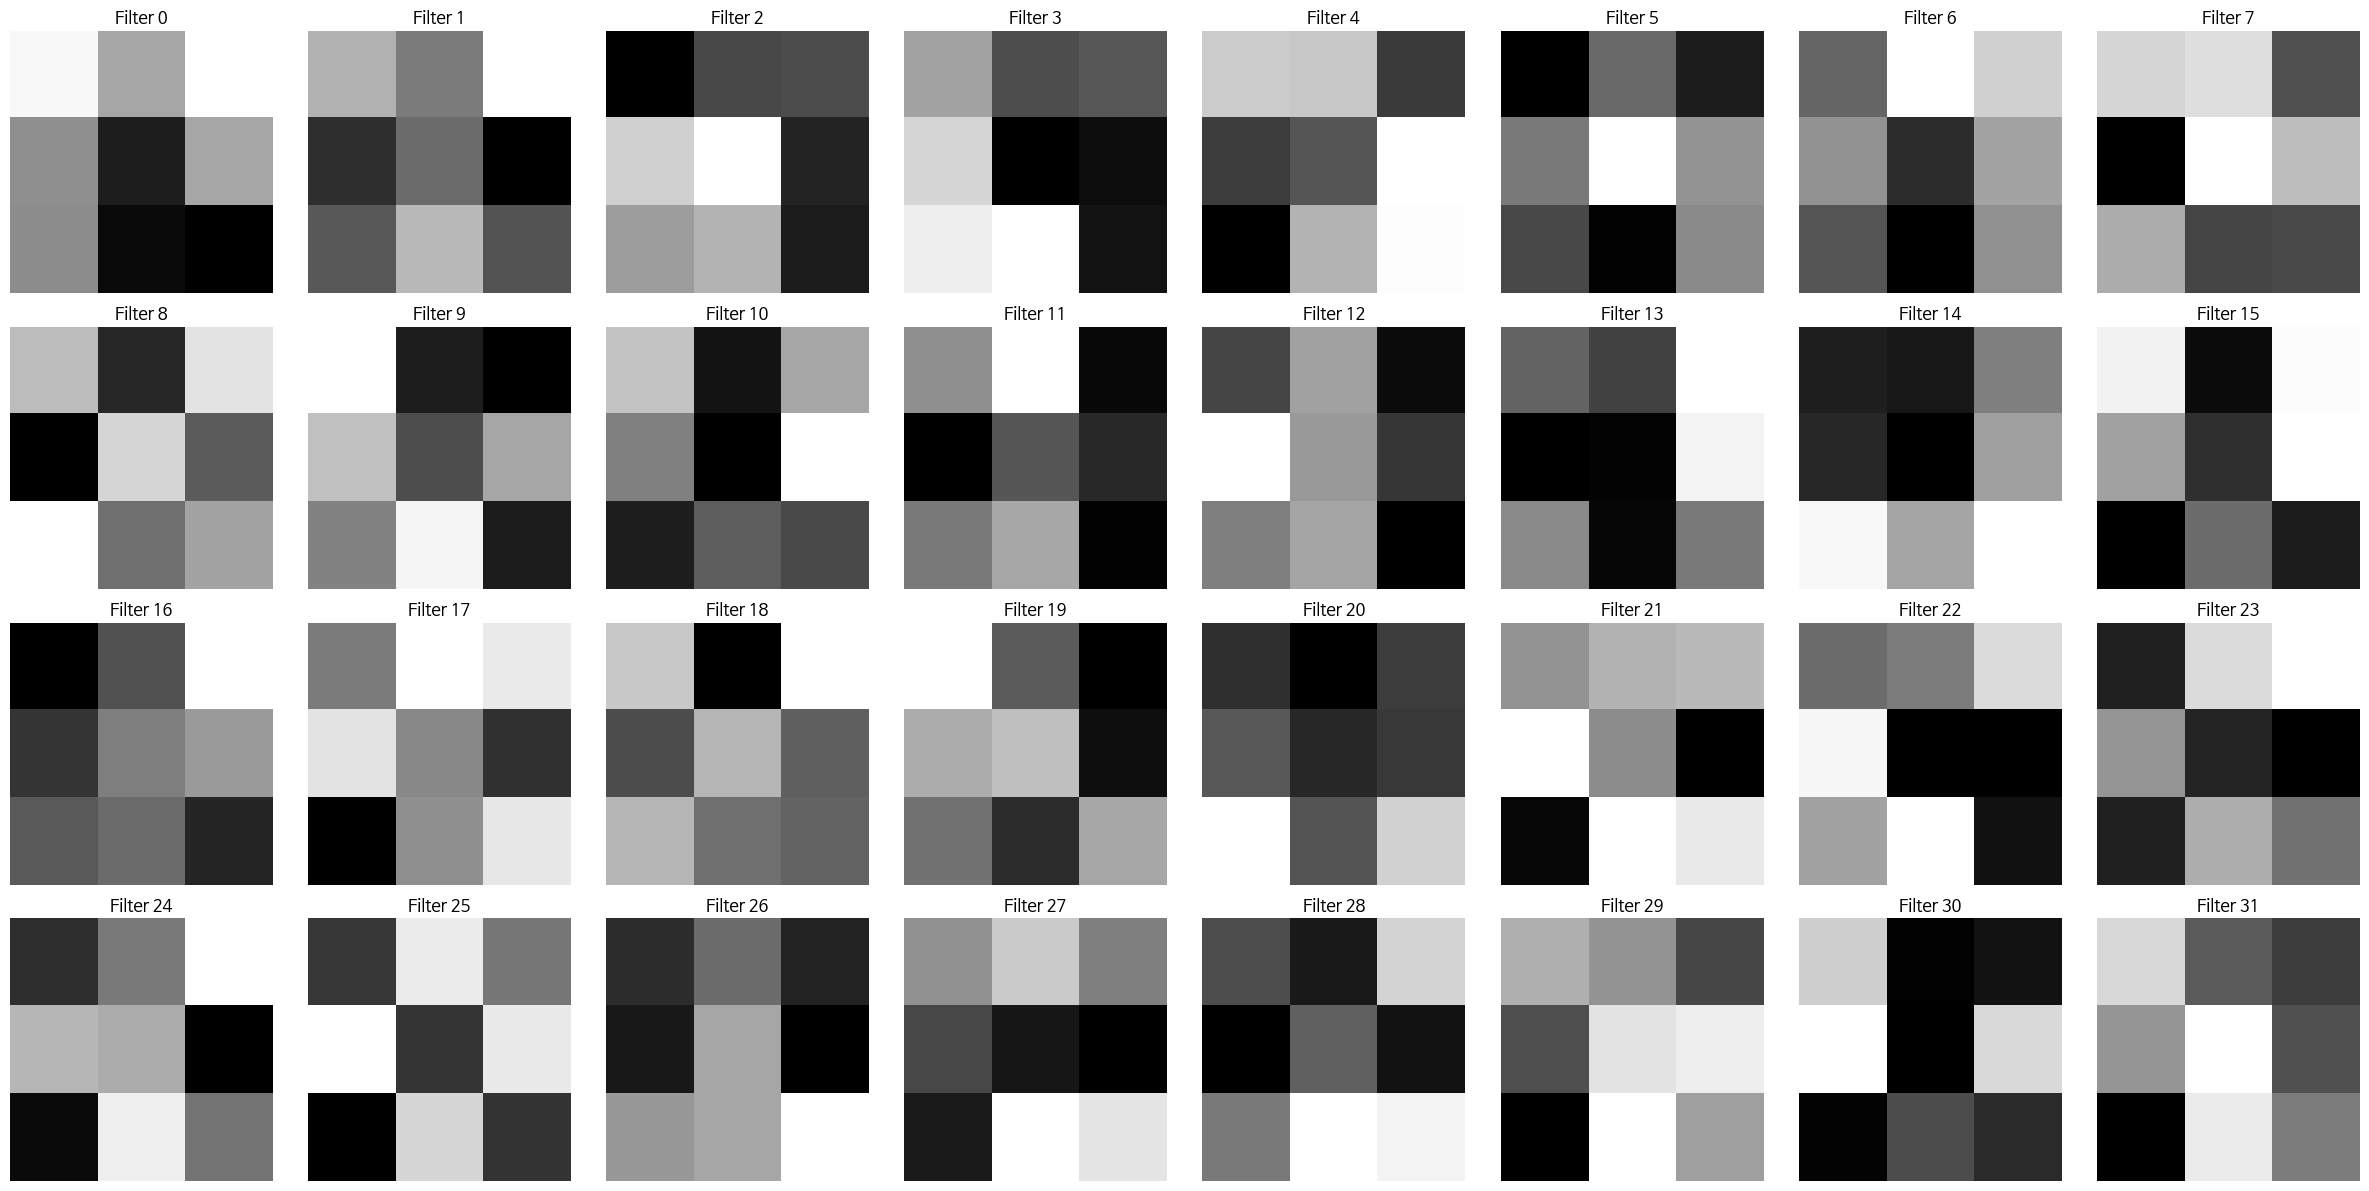

In [21]:
import matplotlib.pyplot as plt

# 첫 번째 합성곱 층의 가중치 가져오기
weights, biases = model.layers[0].get_weights()

# 가중치의 최대값과 최소값을 구해서 정규화에 사용
min_val, max_val = weights.min(), weights.max()

# 첫 번째 층의 출력 채널 수 만큼 반복
n_filters = weights.shape[-1]
n_cols = 8  # 열의 수
n_rows = 4  # 행의 수

plt.figure(figsize=(n_cols * 3, n_rows * 3))

for i in range(n_filters):
    # 각 필터의 첫 채널만 시각화 (필터의 채널이 여러 개인 경우 평균을 낼 수도 있음)
    filter = weights[:, :, 0, i]
    
    # i + 1 번째의 subplot을 생성 (subplot 인덱스는 1부터 시작)
    plt.subplot(n_rows, n_cols, i + 1)
    # 정규화를 통해 픽셀 값의 범위를 0과 1 사이로 조정
    plt.imshow((filter - min_val) / (max_val - min_val), cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')  # 축을 표시하지 않음

plt.tight_layout()
plt.show()

### 2024.01.13 일 코드 간단 총평
- 이진 분류 코드 결과가 정확도 0.83정도로 올라 생각보다 더 높은 수치를 기록하여 만족스러운편
- 하지만 손실값이 너무 높아서 좀더 좋은 하이퍼파라미터와 이미지 데이터를 제공하도록 노력해야함
- 3개화 이상의 화방이 비율이 상대적으로 너무 적어서 수를 더 찾아야한다
- 몇가지 코드구조를 수정해야하고 좀더 내용을 공부할 필요가 무조건적으로 있음
- 특성맵을 살펴보니 그래도 꽤 괜찮은 방향성으로 학습하고 있는거같음